data：https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local').appName('learn_cluster').getOrCreate()

In [2]:
df = spark.read.csv('file:///home/black/PycharmProjects/pyspark/pyspark_learning/Mall_Customers.csv', header=True, inferSchema=True)

In [3]:
df = df.withColumnRenamed('Annual Income (k$)', 'Income').withColumnRenamed('Spending Score (1-100)', 'Spend')

In [4]:
print(type(df))
print(type(spark))
print(df.show(3))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.session.SparkSession'>
+----------+------+---+------+-----+
|CustomerID|Gender|Age|Income|Spend|
+----------+------+---+------+-----+
|         1|  Male| 19|    15|   39|
|         2|  Male| 21|    15|   81|
|         3|Female| 20|    16|    6|
+----------+------+---+------+-----+
only showing top 3 rows

None


In [5]:
# 查看是否有缺失值
df.toPandas().isna().sum()

CustomerID    0
Gender        0
Age           0
Income        0
Spend         0
dtype: int64

In [8]:
from pyspark.ml.feature import VectorAssembler
vecAss = VectorAssembler(inputCols = df.columns[3:], outputCol = 'features')
df_km = vecAss.transform(df).select('CustomerID', 'features')

In [7]:
df_km.show(3)

+----------+-----------+
|CustomerID|   features|
+----------+-----------+
|         1|[15.0,39.0]|
|         2|[15.0,81.0]|
|         3| [16.0,6.0]|
+----------+-----------+
only showing top 3 rows



In [9]:
pd_df = df.toPandas()

In [10]:
pd_df.head()

,CustomerID,Gender,Age,Income,Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


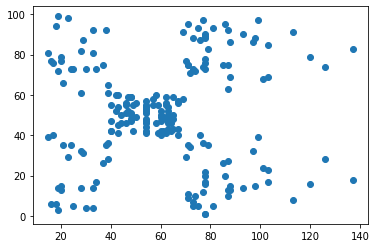

In [12]:
import matplotlib.pyplot as plt
plt.scatter(pd_df.Income, pd_df.Spend)
plt.show()

## KMeans
`class pyspark.ml.clustering.KMeans(self, featuresCol="features", predictionCol="prediction", k=2, initMode="k-means||", initSteps=2, tol=1e-4, maxIter=20, seed=None)
`

**参数解释**

`
initMode: 初始化算法，可以使随机的“random"，也可以是”k-means||"
initSteps: k-means||初始化的步数，需>0
fit(datast,params=None)方法
`

`
cluster: 每个训练数据点预测的聚类中心数据框
clusterSize: 每个簇的大小（簇内数据点的个数）
k:  模型训练的簇个数
predictions: 由模型transform方法产生的数据框
`

In [13]:
from pyspark.ml.clustering import KMeans

cost = list(range(2,20))
for k in range(2, 20):
    kmeans = KMeans(k=k, seed=1)
    km_model = kmeans.fit(df_km)
    # computeCost:计算输入点与其对应的聚类中心之间的平方距离之和。
    cost[k-2] = km_model.computeCost(df_km)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'cost')

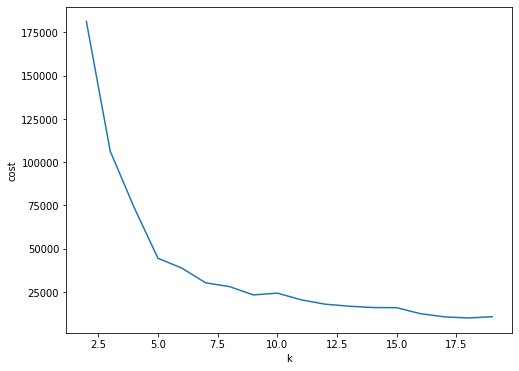

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(range(2,20), cost)
ax.set_xlabel('k')
ax.set_ylabel('cost')

可以见到在k=5时，出现了拐角，我们取k=5

In [16]:
kmeans = KMeans(k=7, seed=1)
km_model = kmeans.fit(df_km)
centers = km_model.clusterCenters()

In [17]:
centers

[array([54.88607595, 49.89873418]),
 array([25.72727273, 79.36363636]),
 array([78.03571429, 81.89285714]),
 array([109.7,  22. ]),
 array([108.18181818,  82.72727273]),
 array([26.30434783, 20.91304348]),
 array([79.        , 16.59259259])]

In [18]:
transformed = km_model.transform(df_km).select('CustomerID', 'prediction')

In [19]:
transformed.show(3)

+----------+----------+
|CustomerID|prediction|
+----------+----------+
|         1|         5|
|         2|         1|
|         3|         5|
+----------+----------+
only showing top 3 rows



In [20]:
df_pred = df.join(transformed, 'CustomerID')

In [21]:
df_pred.show(3)

+----------+------+---+------+-----+----------+
|CustomerID|Gender|Age|Income|Spend|prediction|
+----------+------+---+------+-----+----------+
|         1|  Male| 19|    15|   39|         5|
|         2|  Male| 21|    15|   81|         1|
|         3|Female| 20|    16|    6|         5|
+----------+------+---+------+-----+----------+
only showing top 3 rows



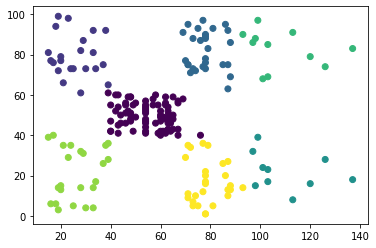

In [26]:
pd_df = df_pred.toPandas()
import matplotlib.pyplot as plt
plt.scatter(pd_df.Income, pd_df.Spend, c=pd_df.prediction)
plt.show()

## BisectingKMeans 二分k均值
`pyspark.ml.clustering.BisectingKMeans(featuresCol='features', predictionCol='prediction', maxIter=20, seed=None, k=4, minDivisibleClusterSize=1.0, distanceMeasure='euclidean')`

二分k均值（bisecting k-means）算法的主要思想是：首先将所有点作为一个簇，然后将该簇一分为二。之后选择能最大程度降低聚类代价函数（也就是误差平方和）的簇划分为两个簇。以此进行下去，直到簇的数目等于用户给定的数目k为止。

   以上隐含着一个原则是：因为聚类的误差平方和能够衡量聚类性能，该值越小表示数据点月接近于它们的质心，聚类效果就越好。所以我们就需要对误差平方和最大的簇进行再一次的划分，因为误差平方和越大，表示该簇聚类越不好，越有可能是多个簇被当成一个簇了，所以我们首先需要对这个簇进行划分。

**参数**

`maxIter: 最大迭代次数
K：聚类簇数
minDivisibleClusterSize: 聚类的最少数据点数(>1)或比例(0-1之间)
fit(dataset, params=None)方法`

**model属性**

`
clusterCenters(): 获取聚类中心，numpy array类型
computeCost()：计算点与其中心的平方和距离
Transform()：对预测数据进行预测
hasSummary:训练模型是否有summary
Summary：获取summary
`

**Summary拥有的属性**

`
cluster：预测的聚类中心
clusterSizes：每个聚类的大小
K：聚类个数
Predictions：由模型的transforn方法产生的预测数据框
`

## GaussianMixture 高斯混合模型
`pyspark.ml.clustering.GaussianMixture(featuresCol='features', predictionCol='prediction', k=2, probabilityCol='probability', tol=0.01, maxIter=100, seed=None)`

对象实现了用来拟合高斯混合模型的 期望最大化 (EM) 算法。它还可以为多变量模型绘制置信区间，同时计算 BIC（Bayesian Information Criterion，贝叶斯信息准则）来评估数据中聚类的数量。

优点:GMM的优点是投影后样本点不是得到一个确定的分类标记，而是得到每个类的概率，这是一个重要信息。GMM不仅可以用在聚类上，也可以用在概率密度估计上。缺点:当每个混合模型没有足够多的点时，估算协方差变得困难起来，同时算法会发散并且找具有无穷大似然函数值的解，除非人为地对协方差进行正则化。GMM每一步迭代的计算量比较大，大于k-means。GMM的求解办法基于EM算法，因此有可能陷入局部极值，这和初始值的选取十分相关了。



注意对于高维数据（具有许多功能），此算法可能表现不佳。这是由于高维数据（a）使得难以聚类（基于统计/理论论证）和（b）高斯分布的数值问题。

**参数**

`fit(dataset,params=None)方法
k: 独立高斯分布的个数，>1
maxIter: 最大迭代次数 >=0
tol: 迭代算法的收敛偏差 >=0
Setter方法和getter方法`

**model属性**

`
gaussianDF: 抽取高斯分布作为数据框，每一行代表高斯分布，有两列：mean（vector)和           cov(Matrix)
hasSummary: 模型是否有总括函数
summary： 获取总括信息
transform(dataset,params=None)方法
weights: 高斯混合模型的权重，和为1
`

In [45]:
spark.stop()